In [1]:
import re
from zipfile import ZipFile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from langdetect import detect, DetectorFactory
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed
from collections import Counter
import nltk
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# Set seeds for reproducible and consistent results
set_seed(42)





/home/tom/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package punkt to /home/tom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Prperocess raw data

In [2]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Amazon_Fashion", trust_remote_code=True)
print(dataset["full"][0])

# Overview
reviews = dataset['full'].to_pandas()


# Check the first 5 observations
print('----------------------------------------\nThe first 5 observations of the dataset:\n----------------------------------------')
display(reviews.head())

# Check the number of observations and features
print('--------------------------\nDimensions of the dataset:\n--------------------------\n')
print('Observations: ' + str(reviews.shape[0]))
print('Variables: ' + str(reviews.shape[1]))
print('Unique Products: ' + str(len(reviews['asin'].unique())))
print('Non-verified purchases: ' + str(len(reviews[reviews['verified_purchase'] == False])))

#
print('\n--------------------------\nMissing data distribution:\n--------------------------\n')
print(reviews.isna().sum())


{'rating': 5.0, 'title': 'Pretty locket', 'text': 'I think this locket is really pretty. The inside back is a solid silver depression and the front is a dome that is not solid (knotted). You could use it to store a small photo, lock of hair, etc but I use it when I need to carry medication with me. Closes securely. High quality & very pretty.', 'images': [], 'asin': 'B00LOPVX74', 'parent_asin': 'B00LOPVX74', 'user_id': 'AGBFYI2DDIKXC5Y4FARTYDTQBMFQ', 'timestamp': 1578528394489, 'helpful_vote': 3, 'verified_purchase': True}
----------------------------------------
The first 5 observations of the dataset:
----------------------------------------


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True


--------------------------
Dimensions of the dataset:
--------------------------

Observations: 2500939
Variables: 10
Unique Products: 874297
Non-verified purchases: 163237

--------------------------
Missing data distribution:
--------------------------

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


In [3]:
# Check for bot_like behavior
reviews['datetime'] = pd.to_datetime(reviews['timestamp'], unit='ms')
reviews['date'] = reviews['datetime'].dt.strftime('%Y-%m-%d')

# Group_by to identify how manny reviews users make per day
review_counts = reviews[['user_id', 'date','text']].groupby(['user_id', 'date']).count()
review_counts.reset_index(inplace=True)
review_counts.rename(columns={'text': 'count'}, inplace=True)
review_counts.sort_values('count', ascending=False, inplace=True)
review_counts.head(10)

,user_id,date,count
339362,AEM5PO3PITEPDNNATSGM2PD6C62Q,2018-06-29,18
1030514,AFR2XB7TRMQJCRB6INYP2W73EH5A,2021-06-08,16
305453,AEKEF7PBXCP345X2UPV3IJY6QMNQ,2017-01-06,13
1022576,AFQNKOJVCTSPUXQIHHKIZHUC4U2Q,2014-12-04,13
2004685,AHF7II6UR3KZ7456G4LVM5K4JVQQ,2019-01-04,13
896044,AFJWIAJZOMSJFKQQDMOXUEJZKDVQ,2018-07-10,12
1582198,AGON3GV6Q37EUUSTQUWEAZ35D5JA,2017-04-15,12
1148317,AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,2020-11-29,11
443634,AERPMJNZRD76NEI6NJBPRXKKEPMQ,2022-05-16,11
2289655,AHUEULPD67THST4AIUTZFI7GQAEQ,2017-11-17,10


In [4]:
# Get an understanding of commenting behaviors to find a proper threshold
for i in range(0,20,1):
    unique_users= len(review_counts[review_counts['count']>i]['user_id'].unique())
    print(f'{unique_users} users have posted more than {i} reviews on at least one day')

2035490 users have posted more than 0 reviews on at least one day
83488 users have posted more than 1 reviews on at least one day
10351 users have posted more than 2 reviews on at least one day
2907 users have posted more than 3 reviews on at least one day
872 users have posted more than 4 reviews on at least one day
379 users have posted more than 5 reviews on at least one day
148 users have posted more than 6 reviews on at least one day
71 users have posted more than 7 reviews on at least one day
26 users have posted more than 8 reviews on at least one day
15 users have posted more than 9 reviews on at least one day
9 users have posted more than 10 reviews on at least one day
7 users have posted more than 11 reviews on at least one day
5 users have posted more than 12 reviews on at least one day
2 users have posted more than 13 reviews on at least one day
2 users have posted more than 14 reviews on at least one day
2 users have posted more than 15 reviews on at least one day
1 users 

In [5]:
# Set threshhold for bot_behavior to 3 or more reviews on one day
threshold = 3
bot_users = review_counts[review_counts['count']>=threshold]
bot_users_id_list = bot_users['user_id'].unique().tolist()
bot_users_id_list

['AEM5PO3PITEPDNNATSGM2PD6C62Q',
 'AFR2XB7TRMQJCRB6INYP2W73EH5A',
 'AEKEF7PBXCP345X2UPV3IJY6QMNQ',
 'AFQNKOJVCTSPUXQIHHKIZHUC4U2Q',
 'AHF7II6UR3KZ7456G4LVM5K4JVQQ',
 'AFJWIAJZOMSJFKQQDMOXUEJZKDVQ',
 'AGON3GV6Q37EUUSTQUWEAZ35D5JA',
 'AFXF3EGQTQDXMRLDWFU7UBFQZB7Q',
 'AERPMJNZRD76NEI6NJBPRXKKEPMQ',
 'AHUEULPD67THST4AIUTZFI7GQAEQ',
 'AGWSCUQ6FPLVB4JD457YOQO6BBVA',
 'AFCXBV3VMX2TP5V4RBPM744BBZAA',
 'AGMLJDY5MWQUGPBA3LIROCYR743Q',
 'AE5XME5D6REQUOXUCWIR7NIO7QAA',
 'AEMT4Q3OEWSJWLOWNPGL6JLI7IIA',
 'AH4OAL6YYB3HSA25HAEXWBT5255Q',
 'AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1',
 'AEG2MF2H6736V3XILN72GC4FHNHQ',
 'AFAFTYAKD3AZERQRT46PWZ4P2ZPA',
 'AFRKEXHAJU3CWRNGZZ3BB7QKDWDA',
 'AGCQLCCUKY3DD2AIOACFB2GQO6BA',
 'AFDAS2HEWPIDGEUBCRWWHCGRYE4Q',
 'AHL3SPQAC6ZUEHEVS3HBDAK5QK5Q',
 'AGP6XV24ZFWNMOXGBYNPUDTXPNQA',
 'AE22JJNSDFUJU4JXP6NRFBPOSWWA',
 'AHVBC24ZPT5YC5C2ASTQTBCZ5FWA',
 'AF6RFA6T3KGL2PMIAEML5F2HINGQ',
 'AEF5TOMSLTYO5TPZ2RA5JYQOSPSA',
 'AHEHDITUC2UE5DWYN7WFQISC3UZA',
 'AGYWMOABBXZQ73ELMG6FD3HZ3XPQ',
 'AGIQ6I

#### Apply first filters

In [6]:
raw_number_of_reviews = len(reviews)
print('Number of reviews before initial preprocessing: ' + str(raw_number_of_reviews))

# Remove rows with empty text string
reviews = reviews[reviews['text'] != '']
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

# Remove duplicate text
reviews = reviews.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

# Remove non-verified purchases
reviews = reviews[reviews['verified_purchase'] == True]
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

# Remove bot like users
reviews = reviews[~reviews['user_id'].isin(bot_users_id_list)]
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

print('Number of reviews after initial preprocessing: ' + str(len(reviews)))

Number of reviews before initial preprocessing: 2500939
Removed 692 rows
Removed 28878 rows
Removed 190148 rows
Removed 228614 rows
Number of reviews after initial preprocessing: 2272325


Next steps:
- remove non-english reviews
- classify reviews by their sentiment
- generate a balanced dataset (sentiments) that is used for model training

#### Remove non-english content

In [101]:
# Setting a consistent seed
DetectorFactory.seed = 12345

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown/not recognizable'

# Apply the function to detect language
reviews['language'] = reviews['text'].apply(detect_language)

# Count the frequency of each language
language_counts = Counter(reviews['language'])
display(language_counts)


Counter({'en': 2094077,
         'ro': 28409,
         'es': 25603,
         'af': 14973,
         'so': 13116,
         'ca': 9791,
         'fr': 9372,
         'sl': 8827,
         'no': 7836,
         'de': 6655,
         'et': 5440,
         'da': 4919,
         'it': 4729,
         'unknown/not recognizable': 4473,
         'pl': 4368,
         'tl': 3745,
         'nl': 3461,
         'pt': 3193,
         'sq': 2678,
         'cy': 2647,
         'cs': 2580,
         'sv': 1956,
         'vi': 1685,
         'sk': 1498,
         'hu': 1329,
         'id': 1300,
         'fi': 1281,
         'tr': 738,
         'sw': 618,
         'hr': 616,
         'lv': 249,
         'lt': 158,
         'bg': 2,
         'he': 1,
         'ko': 1,
         'zh-cn': 1})

In [102]:
# Remove non-english reviews
reviews_noeng = reviews[reviews['language'] == 'en']
diff = len(reviews) - len(reviews_noeng)
print(f'Removed {diff} rows')


Removed 178248 rows


#### Save intermediate results 1
--> checkpoint1

In [103]:
reviews_noeng.to_csv('checkpoint1.csv', index=False)

## Clean review content

In [2]:
with ZipFile(f'Data/checkpoint1.zip', 'r') as zip:
        with zip.open('checkpoint1.csv') as file:
            df = pd.read_csv(file)
            file.close()

df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True,2020-01-09 00:06:34.489,2020-01-09,en
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True,2020-12-20 01:04:06.701,2020-12-20,en
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True,2015-05-23 01:33:48.000,2015-05-23,en
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True,2018-12-31 20:57:27.095,2018-12-31,en
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True,2015-08-13 14:29:26.000,2015-08-13,en


In [3]:
for i in range(1000):
    print(f'{i}: {df["text"].to_list()[i]}')

0: I think this locket is really pretty. The inside back is a solid silver depression and the front is a dome that is not solid (knotted). You could use it to store a small photo, lock of hair, etc but I use it when I need to carry medication with me. Closes securely. High quality & very pretty.
1: Great
2: One of the stones fell out within the first 2 weeks of wearing it. Stones smaller than expected.
3: Crappy socks. Money wasted. Bought to wear with my tieks. Don’t stay on feet well.
4: I LOVE these glasses!  They fit perfectly over my regular, rectangular glasses that I always have to wear in order to see.  I really appreciate having these pretty and stylish and sturdy sunglasses to wear over my glasses.  I'll buy these again and again whenever I need a new pair, which hopefully won't be too soon.
5: Works OK for adults and is not at all kid friendly as stated. Slides down my 5 year olds face.
6: Great fit
7: Would be five stars but they are just too heavy for the size. So cute, ge

In [17]:
from bs4 import BeautifulSoup

sample = df.iloc[:1000].copy()

def clean_html(text):
    text = BeautifulSoup(text, "lxml").text #HTML
    text = emoji.replace_emoji(text, '') #Emojis
    text = re.sub(r'  ', ' ',text) # Double whitespaces
    return text

sample['cleaned'] = sample['text'].apply(clean_html)




/tmp/ipykernel_10944/3603195847.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [18]:
for i in range(1000):
    print(f'{i}: {sample["cleaned"].to_list()[i]}')

0: I think this locket is really pretty. The inside back is a solid silver depression and the front is a dome that is not solid (knotted). You could use it to store a small photo, lock of hair, etc but I use it when I need to carry medication with me. Closes securely. High quality & very pretty.
1: Great
2: One of the stones fell out within the first 2 weeks of wearing it. Stones smaller than expected.
3: Crappy socks. Money wasted. Bought to wear with my tieks. Don’t stay on feet well.
4: I LOVE these glasses! They fit perfectly over my regular, rectangular glasses that I always have to wear in order to see. I really appreciate having these pretty and stylish and sturdy sunglasses to wear over my glasses. I'll buy these again and again whenever I need a new pair, which hopefully won't be too soon.
5: Works OK for adults and is not at all kid friendly as stated. Slides down my 5 year olds face.
6: Great fit
7: Would be five stars but they are just too heavy for the size. So cute, gets 

In [15]:
for i in range(1000):
    print(f'{i}: {df["text"].to_list()[i]}')

0: I think this locket is really pretty. The inside back is a solid silver depression and the front is a dome that is not solid (knotted). You could use it to store a small photo, lock of hair, etc but I use it when I need to carry medication with me. Closes securely. High quality & very pretty.
1: Great
2: One of the stones fell out within the first 2 weeks of wearing it. Stones smaller than expected.
3: Crappy socks. Money wasted. Bought to wear with my tieks. Don’t stay on feet well.
4: I LOVE these glasses!  They fit perfectly over my regular, rectangular glasses that I always have to wear in order to see.  I really appreciate having these pretty and stylish and sturdy sunglasses to wear over my glasses.  I'll buy these again and again whenever I need a new pair, which hopefully won't be too soon.
5: Works OK for adults and is not at all kid friendly as stated. Slides down my 5 year olds face.
6: Great fit
7: Would be five stars but they are just too heavy for the size. So cute, ge

In [6]:


cleantext = [BeautifulSoup(review_content, "lxml").text for review_content in df['text']]

/tmp/ipykernel_10032/3032416594.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleantext = [BeautifulSoup(review_content, "lxml").text for review_content in df['text']]


KeyboardInterrupt: 

In [ ]:
#Function to check if the review contains any irrelevant keywords
# def contains_irrelevant_keywords(text):
#    keywords = ['shipping', 'delivery']
#    return any(keyword in text.lower() for keyword in keywords)

## Sentiment Analysis
--> script is run in kaggle environment

In [4]:
df  = pd.read_csv('checkpoint1.csv')
len(df)

2094077

In [ ]:
# Spli data in chunks to avoid runtime errors in kaggle
df  = pd.read_csv('checkpoint1.csv')
split = int(len(df)/2)
print(split)
df1 = df.iloc[:split]
df2 = df.iloc[split:]

In [ ]:
split = int(len(df1)/2)
print(split)
df11 = df1.iloc[:split]
df11.to_csv('data/senti_split11.csv')
df12 = df1.iloc[split:]
df11.to_csv('data/senti_split12.csv')

split = int(len(df2)/2)
print(split)
df21 = df2.iloc[:split]
df21.to_csv('data/senti_split21.csv')
df22 = df2.iloc[split:]
df22.to_csv('data/senti_split22.csv')


In [ ]:
# This part is run on kaggle for each split
# afterwards the resulting dataframes including sentiment labels are concatenated

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  

import numpy as np 
import pandas as pd 
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed


# Set random seeds for reproducible and consistent results
set_seed(42)


df = pd.read_csv('/kaggle/input/checkpoint1/checkpoint1.csv')
checkpoint = 'siebert/sentiment-roberta-large-english'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

class ScamDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=self.max_length)
        return inputs

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
model.eval()  # Set the model to evaluation mode

# Create a Dataset and DataLoader
texts = df['text'].copy()
dataset = ScamDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

predictions = []

with torch.no_grad():
    # Wrap the dataloader with tqdm to track progress
    for batch in tqdm(dataloader, desc="Classifying"):
        # Move batch data to GPU
        inputs = {key: val.squeeze(1).to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).tolist()
        predictions.extend(batch_predictions)

print("Classification complete.")



In [ ]:
# Add predictions to DataFrame
df['label'] = predictions
df

#### Save intermediate results 2
--> checkpoint2

In [7]:
sentiments = pd.DataFrame()

for split in [11,12,21,22]:

    with ZipFile(f'Data/senti_split_{split}.zip', 'r') as zip:
        with zip.open(f'senti_split_{split}.csv') as file:
            senti_split = pd.read_csv(file)
            sentiments = pd.concat([sentiments,senti_split])

sentiments.to_csv('checkpoint2.csv', index=False)
sentiments

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True,2020-01-09 00:06:34.489,2020-01-09,en,1
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True,2020-12-20 01:04:06.701,2020-12-20,en,1
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True,2015-05-23 01:33:48.000,2015-05-23,en,0
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True,2018-12-31 20:57:27.095,2018-12-31,en,0
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True,2015-08-13 14:29:26.000,2015-08-13,en,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523515,5.0,Five Stars,Great quality. Sturdy and tight. Came on time....,[],B00YGFMQC0,B00YGFMQC0,AEEMZHE5K6EIQHLIGHCNYJTWDUIA,1474207318000,0,True,2016-09-18 14:01:58.000,2016-09-18,en,1
523516,5.0,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,[],B00YGFMQC0,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ,1466799158000,0,True,2016-06-24 20:12:38.000,2016-06-24,en,1
523517,1.0,Didn’t come with all ten,Says ten tie clips but o only received 7.,[],B00YGFMQC0,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ,1525799105585,0,True,2018-05-08 17:05:05.585,2018-05-08,en,0
523518,3.0,Not checked for quality,When I received them 2-3 of them did not open ...,[],B00YGFMQC0,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ,1482013711000,0,True,2016-12-17 22:28:31.000,2016-12-17,en,0


In [8]:
# Split pos/neg 40/60 to avoid positivity bias in gpt2 as training data
df_pos = sentiments[sentiments['label'] == 1].sample(40000) # 1 = positive
df_neg = sentiments[sentiments['label'] == 0].sample(60000) # 0 = negative
df_sampled = pd.concat([df_pos, df_neg])
df_sampled.to_csv('checkpoint3.csv', index=False)

## Save HF dataset for GPT2-finetuning

In [15]:
with ZipFile('Data/checkpoint3.zip', 'r') as zip:
        with zip.open('checkpoint3.csv') as file:
                df = pd.read_csv(file)
                print(df['label'].value_counts()) # 1 = positive; # 0 = negative
                dataset = Dataset.from_pandas(df)



label
0    60000
1    40000
Name: count, dtype: int64


In [16]:
dataset = dataset.select_columns(['text'])
dataset

Dataset({
    features: ['text'],
    num_rows: 100000
})

In [17]:
dataset.save_to_disk('Data/trainset.hf')

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

## Descriptive statistics of all data (not training data)

In [2]:
# Load original data not sampled
with ZipFile('Data/checkpoint2.zip', 'r') as zip:
        with zip.open('checkpoint2.csv') as file:
                reviews = pd.read_csv(file)

In [3]:
reviews['sentiment'] = reviews['label'].copy()
# Replace 1 with 'POS' and 0 with 'NEG'
reviews['sentiment'].replace({1: 'POS', 0: 'NEG'}, inplace=True)
print(reviews['sentiment'])

0          POS
1          POS
2          NEG
3          NEG
4          POS
          ... 
2094072    POS
2094073    POS
2094074    NEG
2094075    NEG
2094076    POS
Name: sentiment, Length: 2094077, dtype: object


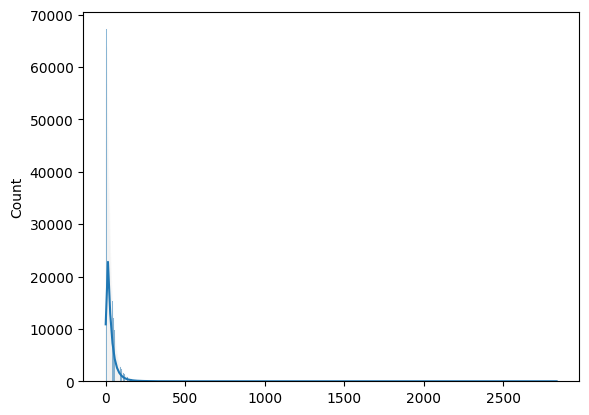

Number of reviews with more than 1024 tokens: 54
Number of reviews with more than 512 tokens: 688
Average number of tokens: 31.85128579321582


In [5]:
# Get a rough understanding of the tokens
revs = reviews['text'].copy()

doc_lengths = []

for rev in revs:
    tokens = nltk.word_tokenize(rev)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.histplot(doc_lengths, kde=True)
#plt.title("Word length of reviews")
plt.savefig('Plots/doc_len.pdf',format='pdf', dpi=1500)
plt.show()

print('Number of reviews with more than 1024 tokens:', str(np.sum(doc_lengths > 1024)))
print('Number of reviews with more than 512 tokens:', str(np.sum(doc_lengths > 512)))
print('Average number of tokens:', str(np.average(doc_lengths)))

#### Clean text and tokenize to create meaningful WordClouds

In [7]:
PUNCTUATION = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""" 


def clean_text(text):
    """Doc cleaning"""
    
    # Lowering text
    text = text.lower()
    
    # Removing punctuation
    text = "".join([c for c in text if c not in PUNCTUATION])
    
    # Removing whitespace and newlines
    text = re.sub('\s+',' ',text)
    
    return text

reviews['cleaned_text'] = reviews['text'].apply(clean_text)

In [8]:
# Split on whitespaces, remove puncutation, remove stopwords
def tokenize_and_process(df, text_column):
    stop_words = set(stopwords.words('english'))
    punctuation_table = str.maketrans('', '', string.punctuation)
    
    def process_text(text):
        # Split text by whitespace
        words = word_tokenize(text)
        # Remove punctuation and stopwords
        cleaned_words = [word.translate(punctuation_table).lower() for word in words if word.isalnum() and word.lower() not in stop_words]
        return cleaned_words
    
    df[text_column + 'SplitAndCleaned'] = df[text_column].apply(process_text)
    return df

# Get splitted cleaned tokens
reviews = tokenize_and_process(reviews, 'text')

# Check the DataFrame
display(reviews)


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label,sentiment,textLengths,cleaned_text,textSplitAndCleaned,textLength
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True,2020-01-09 00:06:34.489,2020-01-09,en,1,POS,67,i think this locket is really pretty the insid...,"[think, locket, really, pretty, inside, back, ...",30
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True,2020-12-20 01:04:06.701,2020-12-20,en,1,POS,1,great,[great],1
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True,2015-05-23 01:33:48.000,2015-05-23,en,0,NEG,20,one of the stones fell out within the first 2 ...,"[one, stones, fell, within, first, 2, weeks, w...",11
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True,2018-12-31 20:57:27.095,2018-12-31,en,0,NEG,21,crappy socks money wasted bought to wear with ...,"[crappy, socks, money, wasted, bought, wear, t...",10
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True,2015-08-13 14:29:26.000,2015-08-13,en,1,POS,64,i love these glasses they fit perfectly over m...,"[love, glasses, fit, perfectly, regular, recta...",27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094072,5.0,Five Stars,Great quality. Sturdy and tight. Came on time....,[],B00YGFMQC0,B00YGFMQC0,AEEMZHE5K6EIQHLIGHCNYJTWDUIA,1474207318000,0,True,2016-09-18 14:01:58.000,2016-09-18,en,1,POS,14,great quality sturdy and tight came on time gr...,"[great, quality, sturdy, tight, came, time, gr...",8
2094073,5.0,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,[],B00YGFMQC0,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ,1466799158000,0,True,2016-06-24 20:12:38.000,2016-06-24,en,1,POS,31,the tie tacks were the size that allowed them ...,"[tie, tacks, size, allowed, used, add, militar...",16
2094074,1.0,Didn’t come with all ten,Says ten tie clips but o only received 7.,[],B00YGFMQC0,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ,1525799105585,0,True,2018-05-08 17:05:05.585,2018-05-08,en,0,NEG,10,says ten tie clips but o only received 7,"[says, ten, tie, clips, received, 7]",6
2094075,3.0,Not checked for quality,When I received them 2-3 of them did not open ...,[],B00YGFMQC0,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ,1482013711000,0,True,2016-12-17 22:28:31.000,2016-12-17,en,0,NEG,19,when i received them 23 of them did not open p...,"[received, open, properly, looks, though, brea...",7


Number of reviews with more than 1024 tokens: 0
Number of reviews with more than 512 tokens: 18
Number of reviews with more than 150 tokens: 1898
Average number of tokens: 13.44116095062407


#### Rating distribution

In [6]:
ratings = pd.DataFrame(reviews['rating'].value_counts())
ratings

,count
rating,
5.0,1176938
4.0,294356
1.0,259760
3.0,211405
2.0,151618


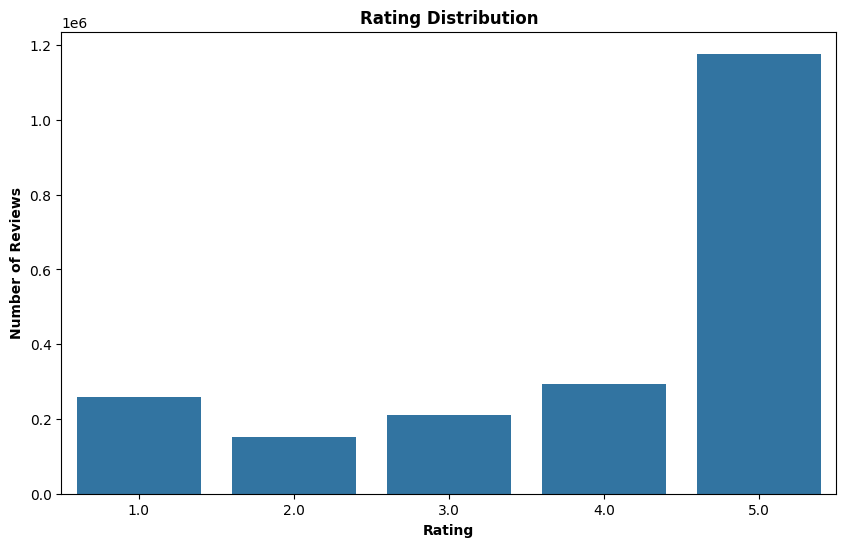

In [9]:
plt.figure(figsize=(10, 6))
# Plot bar graph using seaborn
sns.barplot(x='rating', y='count', data=ratings)
# Set plot title and labels
plt.title('Rating Distribution', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')

#Save the plot
plt.savefig('Plots/rating_distribution_all.pdf',format='pdf', dpi=1500)

# Show the plot
plt.show()

#### Sentiment distribution

In [10]:
# Group by Review_Score and Sentiment
sentiment_distribution = reviews.groupby(['rating','sentiment']).size().reset_index(name='Count')
sentiment_distribution 

,rating,sentiment,Count
0,1.0,NEG,249857
1,1.0,POS,9903
2,2.0,NEG,135674
3,2.0,POS,15944
4,3.0,NEG,132765
5,3.0,POS,78640
6,4.0,NEG,42416
7,4.0,POS,251940
8,5.0,NEG,23329
9,5.0,POS,1153609


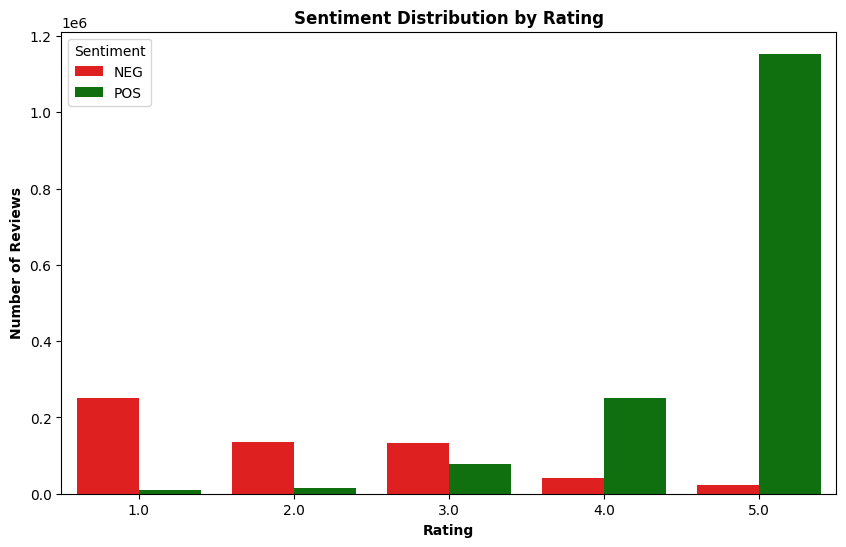

In [11]:
# Sentiment distributions

plt.figure(figsize=(10, 6))
# Plot bar graph using seaborn
sns.barplot(x='rating', y='Count', hue='sentiment', data=sentiment_distribution, palette=['red', 'green'])
# Set plot title and labels
plt.title('Sentiment Distribution by Rating', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')
plt.legend(title='Sentiment')

# Save the plot
plt.savefig('Plots/sentiment_dist_by_rating.pdf',format='pdf', dpi=1500)

# Show the plot
plt.show()

#### WordClouds

In [13]:
# Combine the words into a single string
text = ' '.join([' '.join(review) for review in reviews['textSplitAndCleaned']])

# Wordcloud of common words
wordcloud = WordCloud(width=4000, height=2000, background_color ='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('Plots/wordcloud.pdf', format='pdf', dpi=1500)
plt.show()

In [ ]:
# Define a function to generate word cloud for a given rating
def generate_wordcloud_for_rating(df, rating):
    # Filter the DataFrame for the given rating
    filtered_df = df[df['Score'] == rating]
    # Combine the text from the 'Cleaned_Text' column into a single string
    text = ' '.join([' '.join(review) for review in filtered_df['textSplitAndCleaned']])
    # Generate the word cloud
    wordcloud = WordCloud(width=4000, height=2000, background_color='black').generate(text)
    return wordcloud

# Create a figure with subplots for each rating
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Generate and plot word clouds for each rating
for rating in range(1, 6):
    wordcloud = generate_wordcloud_for_rating(reviews, rating)
    ax = axes[(rating-1) // 2, (rating-1) % 2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Rating {rating}', fontsize=16, weight='bold')
    ax.axis('off')

# Adjust layout and remove the empty subplot
plt.delaxes(axes[2][1])  # remove the empty subplot if there is any
plt.savefig('Plots/wordclouds_by_rating.pdf', format='pdf', dpi=1500)
plt.show()

## Descriptive statistics of training data

In [10]:
# Load sampled training data
with ZipFile('Data/checkpoint3.zip', 'r') as zip:
        with zip.open('checkpoint3.csv') as file:
                reviews = pd.read_csv(file)

In [11]:
ratings = pd.DataFrame(reviews['rating'].value_counts())
ratings

,count
rating,
5.0,33010
1.0,25751
3.0,15933
2.0,14191
4.0,11115


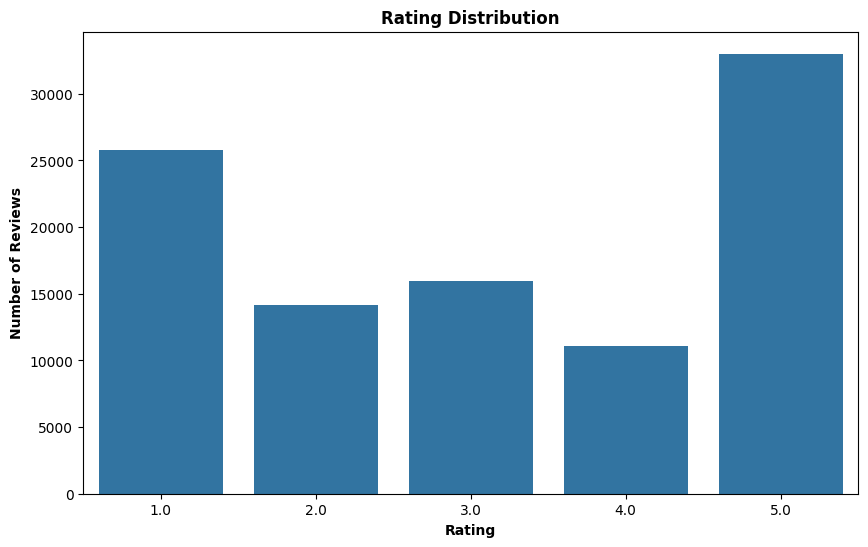

In [12]:
plt.figure(figsize=(10, 6))
# Plot bar graph using seaborn
sns.barplot(x='rating', y='count', data=ratings)
# Set plot title and labels
plt.title('Rating Distribution', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')

#Save the plot
plt.savefig('Plots/rating_distribution_train.pdf',format='pdf', dpi=1500)

# Show the plot
plt.show()

#### BERTopic results
--> from topic_modelling.ipynb run on kaggle

In [13]:
with ZipFile('Data/topic_models.zip', 'r') as zip:
        
        # Topic modelling with review content
        with zip.open('text_topics.csv') as file:
                text_topics = pd.read_csv(file) 
                file.close()
        
        # Topic modelling with titles of reviews 
        with zip.open('title_topics.csv') as file:
                title_topics = pd.read_csv(file)
                file.close()


# Also for product names interesting?

In [14]:
display(text_topics)

,Topic,Count,Name,Representation,Representative_Docs
0,0,51963,0_size_fit_small_dress,"['size', 'fit', 'small', 'dress', 'like', 'wea...","[""SPAAAAAACE PAAAAANTTTSSS!<br /><br />I can n..."
1,1,12857,1_earrings_necklace_ring_like,"['earrings', 'necklace', 'ring', 'like', 'colo...","['I received this ring today, the shipping was..."
2,2,15737,2_quality_cheap_great_good,"['quality', 'cheap', 'great', 'good', 'love', ...","[""Cheap , flimsy, broke in the first week,scre..."
3,3,4756,3_watch_band_wrist_strap,"['watch', 'band', 'wrist', 'strap', 'br', 'tim...","[""The Beauty7 Heavy Black 18-24mm Stainless St..."
4,4,4921,4_glasses_mask_sunglasses_lenses,"['glasses', 'mask', 'sunglasses', 'lenses', 'f...","[""Lost a valve on my previous mask, and this o..."
5,5,3659,5_bag_purse_wallet_zipper,"['bag', 'purse', 'wallet', 'zipper', 'pockets'...","[""It's a good wallet to carry a few cards and ..."
6,6,1525,6_expected_exactly_ok_nothing,"['expected', 'exactly', 'ok', 'nothing', 'desc...","['Exactly as I expected!', 'exactly as expecte..."
7,7,2108,7_shipping_fast_arrived_received,"['shipping', 'fast', 'arrived', 'received', 'p...","['Great product and fast shipping', 'Fast ship..."
8,8,814,8_pin_pins_one_plugs,"['pin', 'pins', 'one', 'plugs', 'br', 'get', '...","['Made well and looks very pretty, but it is h..."
9,9,611,9_lights_battery_light_work,"['lights', 'battery', 'light', 'work', 'batter...","[""It's pretty much useless since the brand new..."


In [15]:
display(title_topics)

,Topic,Count,Name,Representation,Representative_Docs
0,0,34307,0_small_fit_size_dress,"['small', 'fit', 'size', 'dress', 'great', 'co...",['Material was a really loose fit and way to b...
1,1,21747,1_cute_love_disappointed_beautiful,"['cute', 'love', 'disappointed', 'beautiful', ...","['Super cute and good quality', 'This is a rea..."
2,2,14308,2_stars_five_star_one,"['stars', 'five', 'star', 'one', 'three', 'fou...","['Five Stars', 'Five Stars', 'Five Stars']"
3,3,15655,3_quality_buy_cheap_product,"['quality', 'buy', 'cheap', 'product', 'money'...","[""Cheap quality. Don't recommend."", 'Poor qual..."
4,4,5994,4_watch_broke_band_broken,"['watch', 'broke', 'band', 'broken', 'belt', '...","['Strap broke within two weeks.', 'Zipper brok..."
5,5,3907,5_color_colors_smell_red,"['color', 'colors', 'smell', 'red', 'green', '...",['... vibrant bright yellow shown n picture in...
6,6,1416,6_sun_summer_waterproof_breathable,"['sun', 'summer', 'waterproof', 'breathable', ...","['Great sun protection', 'Great sun protection..."
7,7,884,7_see_hole_holes_blurry,"['see', 'hole', 'holes', 'blurry', 'unflatteri...","['See through', 'See through!', 'See through!']"
8,8,875,8_pass_go_beware_avoid,"['pass', 'go', 'beware', 'avoid', 'protection'...","['Pass', 'Pass.', 'Pass']"
9,9,361,9_wanted_exactly_looking_needed,"['wanted', 'exactly', 'looking', 'needed', 'th...","['Exactly what she wanted.', 'Not Exactly What..."
